**Aluno:** Alexandre Esposte Santos

**Data:** 16/10/2023

**Atividade:** Tarefa 3 - Project 1

# **Carregando os pacotes necessários**

In [4]:
from pymatgen.core.composition import *
import ase.db # https://wiki.fysik.dtu.dk/ase/ase/db/db.html
import json
import re


import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns


from sklearn.metrics 	     import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose 	     import ColumnTransformer
from sklearn.pipeline 	     import Pipeline
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing   import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute          import KNNImputer

from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.neighbors       import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from category_encoders.target_encoder import TargetEncoder

import joblib

# **Funções**

In [5]:
def feature_extractor(atom1: str ,atom2: str, material: str, df_reference: pd.DataFrame, column: str) -> dict:
    """Extrai as principais estatísticas da estequiometria AB2"""
    
    a1 = df_reference.query(f'Element == "{atom1}"')
    a2 = df_reference.query(f'Element == "{atom2}"')


    v1 = float(a1[column])
    v2 = float(a2[column])

    media = (v1+v2)/2
    media_pon = (v1+2*v2)/3
    std = np.std([v1,v2])
    std_pon = ((v1 - media_pon)/2) + ((v2 - media_pon)/2)
    minimo = np.min([v1,v2])
    maximo = np.max([v1,v2])

    return {'Material':[material],column+"_media":[media],column+"_media_pon":[media_pon],column+"_std":[std],column+'_std_pon':[std_pon],column+'_minimo':[minimo],column+'_maximo':[maximo]}

# **Classes**

Para simplificar a elaboração de um modelo eu resolvi desenvolver uma classe onde posso incluir os modelos que desejo avaliar junto a um pipeline de pré-processamento. A avaliação pode ser efetuada por duas maneiras, validação cruzada e/ou hold-out.

In [6]:
class ModelCrafter:

    def __init__(self) -> None:
        
        self.models = dict()

        self.results = dict()

        self.results_per_fold = dict()

        self.kf = KFold(n_splits=5) 

    def AddModel(self, modelos : list = []) -> None:
        """Método para adicionar modelos ao objeto. A estrutura é uma lista de tuplas onde a tupla segue o seguinte esquema: (nome do modelo, modelo instanciado)"""
        
        for modelo in modelos:
            self.models[modelo[0]] = modelo[1]

    def RemoveModel(self, nome: str = None, tipo: str = None) -> None:
        """Remove modelos do objeto"""
        
        if tipo == 'all':
            self.models=dict()
            return

        del self.models[nome]

          
    def HoldOut(self,X: pd.DataFrame, y: pd.Series, pipe: Pipeline ,nome: str):
        """Treina somente um modelo dentre os que estão no objeto"""
        if nome not in self.models.keys():
            print('Modelo invalido')
            return
        
        if len(pipe.steps) > 1:
            pipe.steps.pop()
            
        pipe.steps.append((nome,self.models[nome]))

        modelo = pipe

        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

        modelo.fit(x_train,y_train)
        predito = modelo.predict(x_test)

        aux_df = x_test.copy()
    

        return predito, y_test, aux_df

    def Validacao(self, X_train: pd.DataFrame = None, X_test: pd.DataFrame = None , y_train: pd.Series = None, y_test: pd.Series = None, pipe: Pipeline = None):
       
        if len(self.models) == 0:
            return "Nenhum modelo adicionado na estrutura"

        resultados = {'modelo':[],'f1_treino':[], 'f1_teste':[], 'auc_treino':[], 'auc_teste':[]}

        for aux in self.models.items():
            nome_modelo = aux[0]
            modelo = aux[1]

            if len(pipe.steps) > 1:
                pipe.steps.pop()

            
            print(f"-----{nome_modelo}-----")
            pipe.steps.append(("Model",modelo))
            modelo = pipe

            modelo.fit(X_train,y_train)

            pred_train = modelo.predict(X_train)
            pred_test = modelo.predict(X_test)


            f1_train  =  f1_score(y_train,pred_train)
            auc_train =  roc_auc_score(y_train,pred_train)

            f1_test = f1_score(y_test,pred_test)
            auc_test = roc_auc_score(y_test, pred_test)

            resultados['modelo'].append(nome_modelo)
            resultados['f1_treino'].append(f1_train)
            resultados['f1_teste'].append(f1_test)
            resultados['auc_treino'].append(auc_train)
            resultados['auc_teste'].append(auc_test)

        return pd.DataFrame(resultados)
        

    def ValidacaoCruzada(self, X: np.ndarray, y: np.array, pipe: Pipeline = None) -> None:
        """Treina todos os modelos inseridos no objeto através de validação cruzada"""
		
        if len(self.models) == 0:
            return "Nenhum modelo adicionado na estrutura"
        
        for aux in self.models.items():
            nome_modelo = aux[0]
            modelo = aux[1]

            if len(pipe.steps) > 1:
                pipe.steps.pop()

            precision = 0
            recall = 0
            auc = 0
            f1 = []

            resultados_aux = []

            print(f"-----{nome_modelo}-----")
            pipe.steps.append(("Model",modelo))
            modelo = pipe
            for i, (train_index, test_index) in enumerate(self.kf.split(X)):
                #print(f"Fold {i}:")
                
                #print(f"  Train: index={train_index}")
                #print(f"  Test:  index={test_index}")

                X_train = X.loc[train_index,:]
                y_train = y.loc[train_index]

                
                X_test = X.loc[test_index,:]
                y_test = y.loc[test_index]

                
                modelo.fit(X_train,y_train)

                predito = modelo.predict(X_test)
  
                
                resultados_aux.append((y_test,predito)) 
                
                precision  += precision_score(y_test,predito)
                recall += recall_score(y_test,predito)
                auc += roc_auc_score(y_test,predito)
                #f1 += f1_score(y_test,predito)
                f1.append(f1_score(y_test,predito))
                
            self.results[nome_modelo]=[precision/5, recall/5, auc/5,np.mean(f1), np.std(f1)]
            self.results_per_fold[nome_modelo] = resultados_aux

        return self._gerar_resultado()

    def _gerar_resultado(self) -> None:
        """Gera os resultados em uma estrutura DataFrame"""
        
        indices = ['precision','recall','auc','f1','f1_std']
        #display(pd.DataFrame(self.results,index=indices).T)
        return pd.DataFrame(self.results,index=indices).T

# **Carregando e realizando a extração das features para o treinamento do modelo**

In [7]:
df_atoms = pd.read_csv("../datasets/project1/Schleder2019_AtomicTable.csv")

In [8]:
# All possible properties included in the database

keys=['folder', 'uid', 'plasmafrequency_x', 'plasmafrequency_y', 'asr_id', 'cell_area', 
      'has_inversion_symmetry', 'stoichiometry', 'spacegroup', 'spgnum', 'pointgroup', 
      'crystal_type', 'dos_at_ef_nosoc', 'dos_at_ef_soc', 'alphax_el', 'alphay_el', 'alphaz_el', 
      'ehull', 'hform', 'thermodynamic_stability_level', 'spin_axis', 'E_x', 'E_y', 'E_z', 'dE_zx', 
      'dE_zy', 'dim_primary', 'dim_primary_score', 'dim_nclusters_0D', 'dim_nclusters_1D', 'dim_nclusters_2D', 
      'dim_nclusters_3D', 'dim_threshold_0D', 'dim_threshold_1D', 'dim_threshold_2D', 'dim_score_0D', 
      'dim_score_1D', 'dim_score_2D', 'dim_score_3D', 'dim_score_01D', 'dim_score_02D', 'dim_score_03D', 
      'dim_score_12D', 'dim_score_13D', 'dim_score_23D', 'dim_score_012D', 'dim_score_013D', 'dim_score_023D', 
      'dim_score_123D', 'dim_score_0123D', 'first_class_material', 'minhessianeig', 'dynamic_stability_phonons', 
      'speed_of_sound_x', 'speed_of_sound_y', 'dynamic_stability_stiffness', 'c_11', 'c_12', 'c_13', 
      'c_21', 'c_22', 'c_23', 'c_31', 'c_32', 'c_33', 'magstate', 'is_magnetic', 'nspins', 'evac', 
      'evacdiff', 'dipz', 'efermi', 'gap', 'vbm', 'cbm', 'gap_dir', 'gap_dir_nosoc', 'gap_nosoc', 
      'workfunction', 'emass_vb_dir1', 'emass_vb_dir2', 'emass_cb_dir1', 'emass_cb_dir2', 
      'has_asr_hse_calculate', 'has_asr_plasmafrequency', 'has_asr_phonons_calculate', 
      'has_asr_database_material_fingerprint', 'has_asr_structureinfo', 'has_asr_pdos', 
      'has_asr_setup_strains', 'has_asr_polarizability', 'has_asr_convex_hull', 'has_asr_magnetic_anisotropy', 
      'has_asr_dimensionality', 'has_asr_setinfo', 'has_asr_phonons', 'has_asr_bader', 
      'has_asr_stiffness', 'has_asr_magstate', 'has_asr_gs_calculate', 'has_asr_gs', 
      'has_asr_bandstructure_calculate', 'has_asr_bandstructure', 'has_asr_projected_bandstructure', 
      'has_asr_pdos_calculate', 'has_asr_emasses_refine', 'has_asr_emasses', 'has_asr_emasses_validate']

data = ase.db.connect('../datasets/project1/c2db-2021-06-24.db')
data_nonMag = data.select(is_magnetic=False) # Creates a object with all the needed information. 
                                             # Excluding magnetic materials.

target='gap'
df_materials = pd.DataFrame(columns=['Material','Space Group',target,'Atom1', 'Atom2'])

for row in data_nonMag:
    try:
        formula_information = Composition(row.formula).as_dict()
        list_ele = list(formula_information.items())          
        
        if (len(list_ele)==2 and list_ele[0][1]==1 and list_ele[1][1]==2): # Only AB2 stoichiometry

            new_entry = [row.formula, row.spacegroup, row[target], list_ele[0][0], list_ele[1][0]]            
            df_materials.loc[len(df_materials)] = new_entry

    except:
        pass

df_materials

,Material,Space Group,gap,Atom1,Atom2
0,AgBr2,P-4m2,0.000000,Ag,Br
1,AgLi2,P-6m2,0.000000,Ag,Li
2,AlI2,P-6m2,0.000000,Al,I
3,AsCl2,P-6m2,0.000000,As,Cl
4,AsS2,P-3m1,0.000000,As,S
...,...,...,...,...,...
620,ZrI2,P-6m2,0.687104,Zr,I
621,ZrO2,P-4m2,4.368627,Zr,O
622,ZrS2,P-3m1,1.159195,Zr,S
623,ZrSe2,P-3m1,0.336550,Zr,Se


O nosso próximo passo consiste em extrair novas features para o dataframe df_materials. Faremos isso conforme sugerido pelo professor e utilizaremos o dataframe df_atoms.

Notamos que os materiais são do tipo AB2, isto é, um átomo do elemento A e dois átomos do elemento B. Deste modo, os pesos utilizados para a média ponderada serão 1 e 2.

Vamos construir um novo dataset de features contendo as estatísticas sugeridas e depois realizaremos um left join com o dataset df_materials.

In [9]:
features = pd.DataFrame()
for column in df_atoms.drop("Element",axis=1):       
    estatisticas = df_materials.apply(lambda x: feature_extractor(x['Atom1'], x['Atom2'],x['Material'], df_atoms, column), axis=1)

    aux = pd.DataFrame()
    for i in estatisticas:
        aux2 = pd.DataFrame(i)

        aux = pd.concat([aux,aux2])
    
    features = pd.concat([features,aux],axis=1)

features = features.reset_index(drop=True)

aux = features.iloc[:,0]

features = features.drop("Material",axis=1)

features['Material'] = aux

Dataset das features

In [10]:
features.head()

,Z_media,Z_media_pon,Z_std,Z_std_pon,Z_minimo,Z_maximo,Electronegativity_media,Electronegativity_media_pon,Electronegativity_std,Electronegativity_std_pon,...,NumberUnfilledOrbitals_std_pon,NumberUnfilledOrbitals_minimo,NumberUnfilledOrbitals_maximo,Polarizability_media,Polarizability_media_pon,Polarizability_std,Polarizability_std_pon,Polarizability_minimo,Polarizability_maximo,Material
0,41.0,39.000000,6.0,2.000000,35.0,47.0,2.445,2.616667,0.515,-0.171667,...,0.000000,1.0,1.0,37.150,32.033333,15.350,5.116667,21.80,52.5,AgBr2
1,25.0,17.666667,22.0,7.333333,3.0,47.0,1.455,1.296667,0.475,0.158333,...,0.000000,1.0,1.0,108.250,126.833333,55.750,-18.583333,52.50,164.0,AgLi2
2,33.0,39.666667,20.0,-6.666667,13.0,53.0,2.135,2.310000,0.525,-0.175000,...,0.666667,1.0,5.0,45.000,41.533333,10.400,3.466667,34.60,55.4,AlI2
3,25.0,22.333333,8.0,2.666667,17.0,33.0,2.670,2.833333,0.490,-0.163333,...,0.333333,1.0,3.0,22.185,19.646667,7.615,2.538333,14.57,29.8,AsCl2
4,24.5,21.666667,8.5,2.833333,16.0,33.0,2.380,2.446667,0.200,-0.066667,...,0.166667,2.0,3.0,24.585,22.846667,5.215,1.738333,19.37,29.8,AsS2


Realizando o left join

In [11]:
df_materials = pd.merge(df_materials,features,on='Material',how='left').drop_duplicates()
df_materials = df_materials.reset_index(drop=True)
df_materials.head()

,Material,Space Group,gap,Atom1,Atom2,Z_media,Z_media_pon,Z_std,Z_std_pon,Z_minimo,...,NumberUnfilledOrbitals_std,NumberUnfilledOrbitals_std_pon,NumberUnfilledOrbitals_minimo,NumberUnfilledOrbitals_maximo,Polarizability_media,Polarizability_media_pon,Polarizability_std,Polarizability_std_pon,Polarizability_minimo,Polarizability_maximo
0,AgBr2,P-4m2,0.0,Ag,Br,41.0,39.000000,6.0,2.000000,35.0,...,0.0,0.000000,1.0,1.0,37.150,32.033333,15.350,5.116667,21.80,52.5
1,AgLi2,P-6m2,0.0,Ag,Li,25.0,17.666667,22.0,7.333333,3.0,...,0.0,0.000000,1.0,1.0,108.250,126.833333,55.750,-18.583333,52.50,164.0
2,AlI2,P-6m2,0.0,Al,I,33.0,39.666667,20.0,-6.666667,13.0,...,2.0,0.666667,1.0,5.0,45.000,41.533333,10.400,3.466667,34.60,55.4
3,AsCl2,P-6m2,0.0,As,Cl,25.0,22.333333,8.0,2.666667,17.0,...,1.0,0.333333,1.0,3.0,22.185,19.646667,7.615,2.538333,14.57,29.8
4,AsS2,P-3m1,0.0,As,S,24.5,21.666667,8.5,2.833333,16.0,...,0.5,0.166667,2.0,3.0,24.585,22.846667,5.215,1.738333,19.37,29.8


Estabelecendo o target:

0 para isolante e 1 para metal

In [12]:
df_materials['target'] = np.where(df_materials['gap'] == 0, 1,0)

Removendo as variáveis que não serão mais necessárias. 

Neste caso estaremos removendo a variável gap, visto que a sua inclusão no treinamento nos levaria a um Target Leakage. Lembremos que o target foi construído com base no gap.

O principal valor está em detectar quais materiais são isolantes ou metais a partir das características dos elementos que os compõem sem a necessidade de realizar cálculos extensos e complexos.

In [13]:
df_materials = df_materials.drop(['Atom1','Atom2','gap'],axis=1)

O dataset final contém 625 materiais com 105 atributos. O mesmo pode ser visualizado na célula a seguir

In [14]:
df_materials.head()

,Material,Space Group,Z_media,Z_media_pon,Z_std,Z_std_pon,Z_minimo,Z_maximo,Electronegativity_media,Electronegativity_media_pon,...,NumberUnfilledOrbitals_std_pon,NumberUnfilledOrbitals_minimo,NumberUnfilledOrbitals_maximo,Polarizability_media,Polarizability_media_pon,Polarizability_std,Polarizability_std_pon,Polarizability_minimo,Polarizability_maximo,target
0,AgBr2,P-4m2,41.0,39.000000,6.0,2.000000,35.0,47.0,2.445,2.616667,...,0.000000,1.0,1.0,37.150,32.033333,15.350,5.116667,21.80,52.5,1
1,AgLi2,P-6m2,25.0,17.666667,22.0,7.333333,3.0,47.0,1.455,1.296667,...,0.000000,1.0,1.0,108.250,126.833333,55.750,-18.583333,52.50,164.0,1
2,AlI2,P-6m2,33.0,39.666667,20.0,-6.666667,13.0,53.0,2.135,2.310000,...,0.666667,1.0,5.0,45.000,41.533333,10.400,3.466667,34.60,55.4,1
3,AsCl2,P-6m2,25.0,22.333333,8.0,2.666667,17.0,33.0,2.670,2.833333,...,0.333333,1.0,3.0,22.185,19.646667,7.615,2.538333,14.57,29.8,1
4,AsS2,P-3m1,24.5,21.666667,8.5,2.833333,16.0,33.0,2.380,2.446667,...,0.166667,2.0,3.0,24.585,22.846667,5.215,1.738333,19.37,29.8,1


In [15]:
df_materials.shape

(625, 105)

# **Breve EDA**

Neste tópico eu pretendo ser bastante breve. Vamos brevemente analisar três questões.

**1. Valores faltantes:** Na base de dados com informações dos átomos há algumas informações nulas e isso pode ter comprometido algumas variáveis.

**2. Valores duplicados**

**3. Desbalanceamento do target:** Verificaremos a quantidade de metais e isolantes

**Valores faltantes**

Notamos que há 12 features contendo 19 valores faltantes. 

Não vejo muitos problemas aqui, podemos lidar com esse problema no pipeline de pré-processamento.

In [16]:
df_materials.isna().sum().to_frame(name='N° de missing').sort_values(by = 'N° de missing',ascending=False).head(20)

,N° de missing
r_d_orbital_std,19
r_d_orbital_media,19
r_p_orbital_media_pon,19
r_p_orbital_std,19
r_p_orbital_std_pon,19
r_p_orbital_minimo,19
r_p_orbital_maximo,19
r_p_orbital_media,19
r_d_orbital_media_pon,19
r_d_orbital_std_pon,19


**Valores duplicados**

Não há instancias duplicadas.

Nós já sabíamos que não haveria valores duplicados devido ao processo de construção deo dataset. Entretanto, é sempre bom verificar essas questões.

In [17]:
df_materials.duplicated().sum()

0

**Desbalanceamento do target**

Notamos que 430 (68,8%) dos materiais são metais e 195 (31,2%) são isolantes. Portanto, é notável o desbalanceamento entre as classes

In [18]:
df_materials['target'].value_counts(normalize=True).mul(100)

1    68.8
0    31.2
Name: target, dtype: float64

In [19]:
df_materials['target'].value_counts(normalize=False)

1    430
0    195
Name: target, dtype: int64

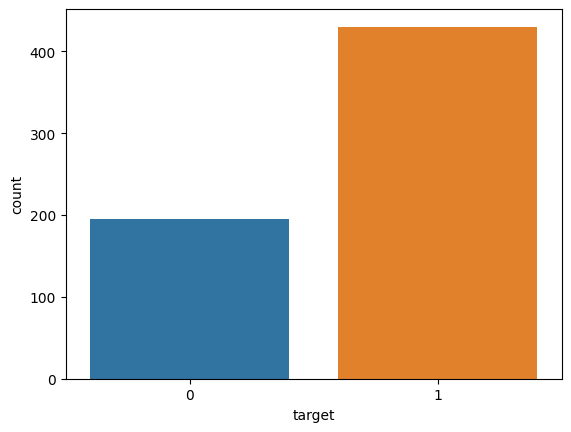

In [20]:
_ = sns.countplot(data=df_materials,x='target')

# **Preparando os datasets para a avaliação**

Separando entre features e target

In [21]:
X = df_materials.drop(['Material','target'],axis=1)
y = df_materials['target']

Separando em treino e teste. Vamos utilizar as seguintes proporções:

treino = 80% -> 500 materiais

teste = 20% -> 125 materiais

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 0)

Verificando o split e a estratificação.

Analisando os valores a seguir podemos concluir que a repartição dos dados foi efetuada corretamente.

In [23]:
print(f"Dimensões X treino: {X_train.shape}\nDimensões y treino: {y_train.shape}\n\nDimensões X teste:  {X_test.shape}\nDimensões y teste:  {y_test.shape}")


Dimensões X treino: (500, 103)
Dimensões y treino: (500,)

Dimensões X teste:  (125, 103)
Dimensões y teste:  (125,)


A estratificação conservou a proporção entre os metais e isolante

In [24]:
y_train.value_counts(normalize=True).mul(100)

1    68.8
0    31.2
Name: target, dtype: float64

In [25]:
y_test.value_counts(normalize=True).mul(100)

1    68.8
0    31.2
Name: target, dtype: float64

In [26]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# **Critérios de avaliação**

As métricas que estaremos avaliando estão listas a seguir:

* **Precision score**
* **Recall score**
* **F1 score**
* **AUC**


Nesta situação não faz sentido utilizarmos a acurácia, visto que estamos lidando com um problema de classes desbalanceada.

Por eu não ser da área de materiais eu não sei exatamente qual a métrica que eu deveria focar, entretanto, estarei me baseando em maximizar o f1_score.

Além de buscar pelo modelo com as melhores métricas, buscamos também pelo modelo mais simples.

# **Modelagem**

A modelagem consistirá na avaliação de modelos pelo método de validação cruzada. Para simplificar esse processo, foi desenvolvido uma classe que nos permite adicionar todos os modelos que desejamos testar, além de podermos incluir uma pipeline de pré-processamento.

A validação cruzada será realizada no dataset de treino e a validação no dataset de teste.  Efetuar a validação cruzada no dataset de treino nos permite, implicitamente, criar três conjuntos de dados: treino, validação e teste. Onde o treino e a validação são advindos da validação cruzada e o dataset de teste foi separado anteriormente.

Com um modelo estabelecido iremos efetuar o treinamento utilizando toda a base de treino e a validação na base de teste.

**Instanciando o objeto para a validação dos modelos**

In [27]:
modelcrafter = ModelCrafter()
modelcrafter

In [28]:
modelcrafter.__dict__

{'models': {},
 'results': {},
 'results_per_fold': {},
 'kf': KFold(n_splits=5, random_state=None, shuffle=False)}

**Estabelecendo os modelos**

In [29]:
# Parâmetro class_weight -> balanceamento das classes

modelos = [('regressao_logistica', LogisticRegression(class_weight='balanced', max_iter=100000)),
           ('svc',SVC(class_weight='balanced')),
           ('knn',KNeighborsClassifier()),
           ('arvore',DecisionTreeClassifier(class_weight='balanced', random_state = 0 )),
           ('floresta',RandomForestClassifier(class_weight='balanced',random_state = 0)),
           ('adaboost',AdaBoostClassifier(random_state = 0)),
           ('gradientboost',GradientBoostingClassifier(random_state = 0)),
           ('xgboost',XGBClassifier(random_state = 0)),
           ('lgbm',LGBMClassifier(class_weight='balanced')),
           ('catboost',CatBoostClassifier(verbose=0)),
           ('dummy',DummyClassifier(strategy='uniform'))] 

# O modelo dummy servirá de referência. Sua principal característica consiste em predizer aleatoriamente seguindo uma distribuição uniforme.

Adicionando os modelos na estrutura do objeto modelcrafter

In [30]:
modelcrafter.AddModel(modelos = modelos)
modelcrafter.models

{'regressao_logistica': LogisticRegression(class_weight='balanced', max_iter=100000),
 'svc': SVC(class_weight='balanced'),
 'knn': KNeighborsClassifier(),
 'arvore': DecisionTreeClassifier(class_weight='balanced', random_state=0),
 'floresta': RandomForestClassifier(class_weight='balanced', random_state=0),
 'adaboost': AdaBoostClassifier(random_state=0),
 'gradientboost': GradientBoostingClassifier(random_state=0),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
        

**Desenvolvendo uma pipeline**

**1. Separando as features numéricas das features categóricas**

In [31]:
# Separando as features categoricas
categoricas = X.select_dtypes(include=['object']).columns

# Separando as features numéricas
numericas = X.select_dtypes(exclude=['object']).columns

print(f"Categoricas: {categoricas}\n\nNuméricas: {numericas}")

Categoricas: Index(['Space Group'], dtype='object')

Numéricas: Index(['Z_media', 'Z_media_pon', 'Z_std', 'Z_std_pon', 'Z_minimo', 'Z_maximo',
       'Electronegativity_media', 'Electronegativity_media_pon',
       'Electronegativity_std', 'Electronegativity_std_pon',
       ...
       'NumberUnfilledOrbitals_std', 'NumberUnfilledOrbitals_std_pon',
       'NumberUnfilledOrbitals_minimo', 'NumberUnfilledOrbitals_maximo',
       'Polarizability_media', 'Polarizability_media_pon',
       'Polarizability_std', 'Polarizability_std_pon', 'Polarizability_minimo',
       'Polarizability_maximo'],
      dtype='object', length=102)


**2. Construindo a pipeline para o pré-processamento das features categoricas e numéricas**

In [32]:
numerical_transform = Pipeline([('imputer',KNNImputer()), 
                                ("scaler",StandardScaler())])

categorical_transform = Pipeline([('encoder',TargetEncoder()), 
                                  ('imputer',KNNImputer()),
                                  ('scaler',StandardScaler())])

preprocessor = ColumnTransformer([('categorical',categorical_transform, categoricas), 
                                  ('numeric', numerical_transform,numericas)],
                                remainder='passthrough')


model_pipeline = Pipeline([('preprocessor',preprocessor)])

model_pipeline.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Space Group'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Z_media', 'Z_media_po...
       'Electronegativity_std', 'Electronegativity_std_pon',
       ...
       'NumberUnfilledOrbitals_std', 'NumberUnfilledOrbitals_std_pon',
       'NumberUnfilledOrbitals_minimo', 'NumberUnfilledOrbitals_maximo',
       'Polarizability_media', 'Polarizability_media_pon',
       'Polarizability_std', 'Polarizability_std_pon', 'Polarizability_minimo',
       'Polarizability_maximo'],
      dtype='object', length=102))]))])

Na célula a seguir eu demonstro a saída desse pipeline utilizando toda a nossa base de dados apenas como exemplo. Note que consigo processar todas as features em apenas uma linha de código. 

Ao enviar essa pipeline para o objeto modelcrafter, o objeto incluirá ao final dessa pipeline o modelo de tal modo que o dataset pré-processado será a entrada do modelo tanto para treinamento, tanto para validação. A diferença é apenas nas bases utilizadas, no treinamento será o X_train e no teste o X_test

In [33]:
model_pipeline.fit_transform(X,y)

,categorical__Space Group,numeric__Z_media,numeric__Z_media_pon,numeric__Z_std,numeric__Z_std_pon,numeric__Z_minimo,numeric__Z_maximo,numeric__Electronegativity_media,numeric__Electronegativity_media_pon,numeric__Electronegativity_std,...,numeric__NumberUnfilledOrbitals_std,numeric__NumberUnfilledOrbitals_std_pon,numeric__NumberUnfilledOrbitals_minimo,numeric__NumberUnfilledOrbitals_maximo,numeric__Polarizability_media,numeric__Polarizability_media_pon,numeric__Polarizability_std,numeric__Polarizability_std_pon,numeric__Polarizability_minimo,numeric__Polarizability_maximo
0,1.230736,-0.031650,0.086472,-0.838679,-0.338159,0.538466,-0.476001,0.539109,0.550529,0.172455,...,-1.400994,-0.878806,-0.384091,-1.345374,-0.510521,-0.492414,-0.466254,-0.416985,-0.135750,-0.500468
1,-1.021970,-1.214845,-1.524552,0.751686,0.808336,-1.612818,-0.476001,-2.582484,-3.172410,0.042712,...,-1.400994,-0.878806,-0.384091,-1.345374,2.103597,4.135968,1.063471,-3.017927,2.515973,1.629455
2,-1.021970,-0.623248,0.136816,0.552890,-2.201212,-0.940542,-0.153856,-0.438360,-0.314397,0.204891,...,0.511887,0.600665,-0.384091,0.313125,-0.221902,-0.028599,-0.653684,-0.598064,0.969855,-0.445071
3,-1.021970,-1.214845,-1.172140,-0.639883,-0.194847,-0.671631,-1.227672,1.248561,1.161617,0.091365,...,-0.444554,-0.139070,-0.384091,-0.516125,-1.060736,-1.097163,-0.759136,-0.699943,-0.760243,-0.934094
4,-0.425590,-1.251820,-1.222485,-0.590185,-0.159019,-0.738859,-1.227672,0.334155,0.071059,-0.849275,...,-0.922774,-0.508938,0.834471,-0.516125,-0.972495,-0.940931,-0.850011,-0.787738,-0.345642,-0.934094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,-1.021970,0.375073,0.816467,-0.788980,-1.233857,0.874605,-0.153856,-0.879797,-0.577635,0.658993,...,1.946548,1.710269,-0.384091,1.556999,0.984049,1.038988,0.588272,0.601808,0.969855,0.808050
621,1.230736,-1.288795,-1.449035,0.155299,0.378400,-1.276680,-0.851836,0.349921,0.888978,1.923992,...,1.468327,1.340401,0.834471,1.556999,0.444312,0.083367,1.144123,1.138824,-1.566125,0.808050
622,-0.425590,-0.992996,-1.046279,-0.242292,0.091777,-0.738859,-0.851836,-1.005922,-0.728056,0.529250,...,1.468327,1.340401,0.834471,1.556999,0.704070,0.543276,0.876610,0.880376,-0.345642,0.808050
623,-0.425590,-0.327449,-0.140079,-1.136873,-0.553126,0.471239,-0.851836,-1.053219,-0.784465,0.480596,...,1.468327,1.340401,0.834471,1.556999,0.830363,0.766884,0.746545,0.754719,0.247757,0.808050


**3. Realizando a validação cruzada**

O modelo xgboost foi o que melhor performou no nosso dataset de treino. Com ele obtemos um f1 score de 96,5% e um auc de 94%.

O modelo Dummy (aleatório), obteve um auc de 50% como esperado e um f1 de aproximadamente 59%. É curioso observar que 68% (precision) da vezes o modelo aleatório pode classificar corretamente os metais.

In [34]:
baseline = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

baseline.sort_values(by='f1',ascending=False)

-----regressao_logistica-----
-----svc-----
-----knn-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboost-----
-----xgboost-----
-----lgbm-----
-----catboost-----
-----dummy-----


,precision,recall,auc,f1,f1_std
xgboost,0.959174,0.970628,0.941434,0.964749,0.015650
catboost,0.954033,0.973732,0.937276,0.963567,0.018683
gradientboost,0.956104,0.959559,0.932328,0.957706,0.015696
lgbm,0.953213,0.956493,0.927569,0.954687,0.011797
arvore,0.954995,0.933570,0.919185,0.943952,0.012287
adaboost,0.904537,0.927324,0.853645,0.915313,0.017593
floresta,0.895166,0.917060,0.839166,0.905435,0.016429
knn,0.820036,0.874222,0.724899,0.844973,0.015316
svc,0.868964,0.813599,0.772187,0.839606,0.026107
regressao_logistica,0.865023,0.775521,0.757143,0.817444,0.050984


OBS: Eu tentei diversas outras pipelines, incluindo seleção de features com a classe seleckbest, polynomialFeatures, outros encoders e até tentei criar novos ensembles com a classe StackingClassifier. Mas nenhuma dessas modificações deram resultados melhores. Optei por remover do notebook para não deixar poluído

Antes de validarmos, vamos tunar o modelo através da classe RandomizedSearchCV. Basicamente o que estamos fazendo consiste em informar uma lista de possíveis valores para os hiperparâmetros, o método então buscará aleatoriamente pelo conjunto de hiperparâmetros que tem o maior score.

In [35]:
xgb = XGBClassifier(n_estimators = 100, random_state = 0)
params_space = {"model__learning_rate":np.linspace(1e-3,1e-1,1000),
                "model__max_depth" : np.arange(2,20),
                "model__subsample" : np.linspace(0,1,1000),
                "model__reg_alpha" : np.linspace(0,10,1000),
                "model__reg_lambda": np.linspace(0,10,1000),
                "model__max_leaves": np.arange(2,256),
                "model__gamma"     :np.linspace(0,10,1000) }

model  = Pipeline([('preprocessor',preprocessor), ('model',xgb)])
buscador_xgb = RandomizedSearchCV(estimator = model, param_distributions = params_space, n_iter = 500, scoring='f1', verbose = 1, n_jobs = -1)
buscador_xgb.fit(X_train,y_train)

buscador_xgb.best_params_, buscador_xgb.best_score_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


({'model__subsample': 0.986986986986987,
  'model__reg_lambda': 4.844844844844845,
  'model__reg_alpha': 0.10010010010010009,
  'model__max_leaves': 189,
  'model__max_depth': 12,
  'model__learning_rate': 0.06254054054054055,
  'model__gamma': 0.3003003003003003},
 0.9561595494046289)

Vamos tunar também o modelo lgbm, visto que é um algoritmo muito poderoso e bastante utilizado.

In [36]:
lgbm = LGBMClassifier(n_estimators = 100, random_state = 0)
params_space  = {"model__learning_rate": np.linspace(1e-3 , 1e-1,1000),
                 "model__num_leaves": np.arange(2,258),
                 "model__min_child_samples":np.arange(1,100,1000),
                 "model__subsample":np.linspace(0.05,1,1000),
                 "model__colsample_bytree":np.linspace(0.1,1,1000)}

model  = Pipeline([('preprocessor',preprocessor), ('model',lgbm)])
buscador_lgbm = RandomizedSearchCV(estimator = model, param_distributions = params_space, n_iter = 500, scoring='f1', verbose = 1, n_jobs = -1)
buscador_lgbm.fit(X_train,y_train)

buscador_lgbm.best_params_, buscador_lgbm.best_score_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


({'model__subsample': 0.6614614614614615,
  'model__num_leaves': 25,
  'model__min_child_samples': 1,
  'model__learning_rate': 0.09157657657657658,
  'model__colsample_bytree': 0.7648648648648648},
 0.9693832290135985)

In [37]:
modelos = [('regressao_logistica', LogisticRegression(class_weight='balanced', max_iter=100000)),
           ('svc',SVC(class_weight='balanced')),
           ('knn',KNeighborsClassifier()),
           ('arvore',DecisionTreeClassifier(class_weight='balanced', random_state = 0 )),
           ('floresta',RandomForestClassifier(class_weight='balanced',random_state = 0)),
           ('adaboost',AdaBoostClassifier(random_state = 0)),
           ('gradientboost',GradientBoostingClassifier(random_state = 0)),
           ('xgboost',XGBClassifier(random_state = 0)),
           ('lgbm',LGBMClassifier(class_weight='balanced')),
           ('catboost',CatBoostClassifier(verbose=0)),
           ('dummy',DummyClassifier(strategy='uniform')),
           ('xgboost_tunado',XGBClassifier(n_estimators = 100, random_state= 0,
                                            subsample = buscador_xgb.best_params_['model__subsample'],
                                            reg_lambda = buscador_xgb.best_params_['model__reg_lambda'],
                                            reg_alpha  = buscador_xgb.best_params_['model__reg_alpha'],
                                            max_leaves = buscador_xgb.best_params_['model__max_leaves'],
                                            max_depth = buscador_xgb.best_params_['model__max_depth'],
                                            learning_rate = buscador_xgb.best_params_['model__learning_rate'],
                                            gamma = buscador_xgb.best_params_['model__gamma'] )),
            ('lgbm_tunado',LGBMClassifier(n_estimators = 100, random_state = 0,
                                          learning_rate = buscador_lgbm.best_params_['model__learning_rate'],
                                          num_leaves = buscador_lgbm.best_params_['model__num_leaves'],
                                          min_child_samples= buscador_lgbm.best_params_['model__min_child_samples'],
                                          subsample= buscador_lgbm.best_params_['model__subsample'],
                                          colsample_bytree= buscador_lgbm.best_params_['model__colsample_bytree']))] 

modelcrafter = ModelCrafter()
modelcrafter
modelcrafter.AddModel(modelos = modelos)

Interessante observar que nem sempre o tunning de hiperparâmetros será sempre uma boa solução. Para o xgboost o desempenho piorou, já para o lgbm as métricas melhoraram. Agora devemos validar os modelos na base de teste para decidirmos qual é o melhor.

In [38]:
resultados = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

resultados.sort_values(by='f1',ascending=False)

-----regressao_logistica-----
-----svc-----
-----knn-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboost-----
-----xgboost-----
-----lgbm-----
-----catboost-----
-----dummy-----
-----xgboost_tunado-----
-----lgbm_tunado-----


,precision,recall,auc,f1,f1_std
xgboost,0.959174,0.970628,0.941434,0.964749,0.015650
catboost,0.954033,0.973732,0.937276,0.963567,0.018683
xgboost_tunado,0.948719,0.970829,0.928056,0.959451,0.015322
lgbm_tunado,0.961982,0.956536,0.938239,0.958890,0.014538
gradientboost,0.956104,0.959559,0.932328,0.957706,0.015696
lgbm,0.953213,0.956493,0.927569,0.954687,0.011797
arvore,0.954995,0.933570,0.919185,0.943952,0.012287
adaboost,0.904537,0.927324,0.853645,0.915313,0.017593
floresta,0.895166,0.917060,0.839166,0.905435,0.016429
knn,0.820036,0.874222,0.724899,0.844973,0.015316


Aqui também é muito interessante  notar um detalhe. Essa validação é feita por Hold-Out, diferentemente da validação cruzada, notamos que nesse método os nossos modelos tenderam ao overfitting. Entretanto, mesmo com overfitting observamos que as métricas de treino ainda permanecem próximas das métricas de teste.

Vamos tomar como exemplo o melhor modelo, o xgboost. A diferença entre o treino e o teste é apenas de +- 4pp (pontos percentuais) para o f1 e 7pp para o auc.

Por outro lado, ao compararmos as métricas de teste com as métricas obtidas por validação cruzada o cenário é melhor. Por exemplo o xgboost, apresenta basicamente uma diferença de 1pp para ambas as métricas.

Eu acho importante analisarmos os dois métodos para termos uma noção maior de como o nosso modelo está performando. No final, o nosso modelo será treinado utilizando a base de treino (ou até mesmo toda a base de dados) uma vez que não conseguimos extrair somente um modelo treinado da validação cruzada.

Portanto, vamos selecionar o xgboost, visto que foi o melhor modelo para ambas as métricas adotadas.

In [39]:
modelcrafter = ModelCrafter()
modelcrafter
modelcrafter.AddModel(modelos = modelos)
validacao = modelcrafter.Validacao(X_train,X_test,y_train,y_test,model_pipeline)

validacao.sort_values(by='f1_teste',ascending=False)

-----regressao_logistica-----
-----svc-----
-----knn-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboost-----
-----xgboost-----
-----lgbm-----
-----catboost-----
-----dummy-----
-----xgboost_tunado-----
-----lgbm_tunado-----


,modelo,f1_treino,f1_teste,auc_treino,auc_teste
7,xgboost,1.000000,0.965909,1.000000,0.930083
12,lgbm_tunado,1.000000,0.960452,1.000000,0.917263
8,lgbm,1.000000,0.960000,1.000000,0.924270
9,catboost,1.000000,0.949153,1.000000,0.898629
11,xgboost_tunado,0.988406,0.943820,0.979614,0.885808
6,gradientboost,0.998544,0.932584,0.998547,0.867174
3,arvore,1.000000,0.930233,1.000000,0.888193
4,floresta,1.000000,0.898876,1.000000,0.811270
5,adaboost,0.965517,0.892655,0.937090,0.805456
1,svc,0.879880,0.845238,0.832923,0.771765


In [40]:
best_model = modelcrafter.models['xgboost']

final_model = Pipeline([('preprocessor',preprocessor), ('model',best_model)])

# Salvando o modelo

In [41]:
joblib.dump(final_model, "model.pkl")

['model.pkl']

# Carregando o modelo

Agora, para simular uma produção eu vou carregar o modelo e realizar a predição para toda a base de dados 

In [42]:
model = joblib.load('model.pkl')

In [50]:
df_materials['predito'] = model.predict(X)

df_materials[['Material','target','predito']]

,Material,target,predito
0,AgBr2,1,1
1,AgLi2,1,1
2,AlI2,1,1
3,AsCl2,1,1
4,AsS2,1,1
...,...,...,...
620,ZrI2,0,0
621,ZrO2,0,0
622,ZrS2,0,0
623,ZrSe2,0,0


De 6 predições erradas, 5 são isolantes e 1 é metal.

In [51]:
df_materials.query('target != predito')

,Material,Space Group,Z_media,Z_media_pon,Z_std,Z_std_pon,Z_minimo,Z_maximo,Electronegativity_media,Electronegativity_media_pon,...,NumberUnfilledOrbitals_minimo,NumberUnfilledOrbitals_maximo,Polarizability_media,Polarizability_media_pon,Polarizability_std,Polarizability_std_pon,Polarizability_minimo,Polarizability_maximo,target,predito
29,FeF2,P-4m2,17.5,14.666667,8.5,2.833333,9.0,26.0,2.905,3.263333,...,1.0,4.0,30.850000,21.800000,27.150000,9.050000,3.700000,58.00,0,1
178,CdS2,P1,32.0,26.666667,16.0,5.333333,16.0,48.0,2.135,2.283333,...,0.0,2.0,33.085000,28.513333,13.715000,4.571667,19.370000,46.80,0,1
204,HgSe2,P-6m2,57.0,49.333333,23.0,7.666667,34.0,80.0,2.275,2.366667,...,0.0,2.0,30.255000,28.916667,4.015000,1.338333,26.240000,34.27,0,1
390,OsCl2,P-4m2,46.5,36.666667,29.5,9.833333,17.0,76.0,2.680,2.840000,...,1.0,4.0,35.785000,28.713333,21.215000,7.071667,14.570000,57.00,0,1
430,SnSe2,P-6m2,42.0,39.333333,8.0,2.666667,34.0,50.0,2.255,2.353333,...,2.0,4.0,41.290000,36.273333,15.050000,5.016667,26.240000,56.34,1,0
597,TiH2,P-6m2,11.5,8.000000,10.5,3.500000,1.0,22.0,1.870,1.980000,...,1.0,8.0,48.253554,33.671405,43.746446,14.582149,4.507107,92.00,0,1
